### Importing needed modules

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import os

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### Loading the training and validation dataset using Keras

In [55]:
batch_size = 100
img_height = 150
img_width = 150

train_ds = tf.keras.utils.image_dataset_from_directory(
  r"C:\Users\franc\VSCode\FundAprendAuto\FAA-Project-1\images",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle = True)

val_ds = tf.keras.utils.image_dataset_from_directory(
  r"C:\Users\franc\VSCode\FundAprendAuto\FAA-Project-1\images",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle = True)

Found 6820 files belonging to 150 classes.
Using 5456 files for training.
Found 6820 files belonging to 150 classes.
Using 1364 files for validation.


In [56]:
class_names = train_ds.class_names
print("Existing classes")
print(class_names)

Existing classes
['Abra', 'Aerodactyl', 'Alakazam', 'Alolan Sandslash', 'Arbok', 'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise', 'Bulbasaur', 'Butterfree', 'Caterpie', 'Chansey', 'Charizard', 'Charmander', 'Charmeleon', 'Clefable', 'Clefairy', 'Cloyster', 'Cubone', 'Dewgong', 'Diglett', 'Ditto', 'Dodrio', 'Doduo', 'Dragonair', 'Dragonite', 'Dratini', 'Drowzee', 'Dugtrio', 'Eevee', 'Ekans', 'Electabuzz', 'Electrode', 'Exeggcute', 'Exeggutor', 'Farfetchd', 'Fearow', 'Flareon', 'Gastly', 'Gengar', 'Geodude', 'Gloom', 'Golbat', 'Goldeen', 'Golduck', 'Golem', 'Graveler', 'Grimer', 'Growlithe', 'Gyarados', 'Haunter', 'Hitmonchan', 'Hitmonlee', 'Horsea', 'Hypno', 'Ivysaur', 'Jigglypuff', 'Jolteon', 'Jynx', 'Kabuto', 'Kabutops', 'Kadabra', 'Kakuna', 'Kangaskhan', 'Kingler', 'Koffing', 'Krabby', 'Lapras', 'Lickitung', 'Machamp', 'Machoke', 'Machop', 'Magikarp', 'Magmar', 'Magnemite', 'Magneton', 'Mankey', 'Marowak', 'Meowth', 'Metapod', 'Mew', 'Mewtwo', 'Moltres', 'MrMime', 'Muk'

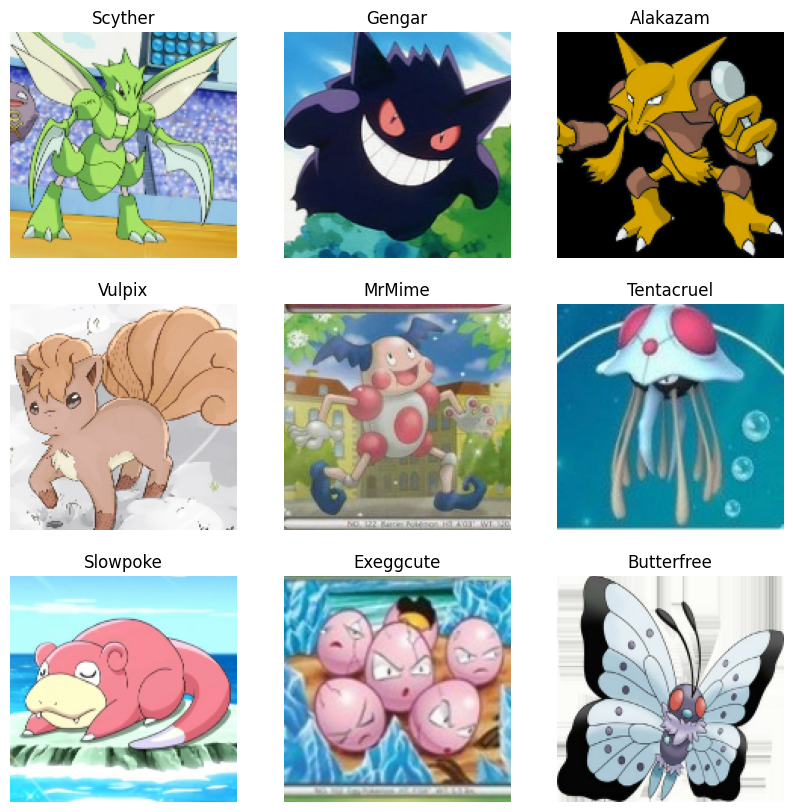

In [57]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [58]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(100, 150, 150, 3)
(100,)


In [59]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [60]:
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.041146476 1.0


In [70]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])

In [71]:
model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [72]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 75, 75, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 37, 37, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 37, 37, 64)       

In [73]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
55/55 [==============================] - 28s 496ms/step - loss: 5.0116 - accuracy: 0.0099 - val_loss: 4.9240 - val_accuracy: 0.0139
Epoch 2/10
55/55 [==============================] - 28s 511ms/step - loss: 4.7297 - accuracy: 0.0214 - val_loss: 4.4385 - val_accuracy: 0.0447
Epoch 3/10
55/55 [==============================] - 27s 495ms/step - loss: 4.1176 - accuracy: 0.0876 - val_loss: 3.9483 - val_accuracy: 0.1063
Epoch 4/10
55/55 [==============================] - 26s 480ms/step - loss: 3.4459 - accuracy: 0.1968 - val_loss: 3.5205 - val_accuracy: 0.1796
Epoch 5/10
55/55 [==============================] - 27s 489ms/step - loss: 2.7294 - accuracy: 0.3215 - val_loss: 3.0997 - val_accuracy: 0.2603
Epoch 6/10
55/55 [==============================] - 27s 495ms/step - loss: 2.1421 - accuracy: 0.4481 - val_loss: 3.0131 - val_accuracy: 0.2933
Epoch 7/10
55/55 [==============================] - 27s 486ms/step - loss: 1.6345 - accuracy: 0.5702 - val_loss: 3.0481 - val_accuracy: 0.3270

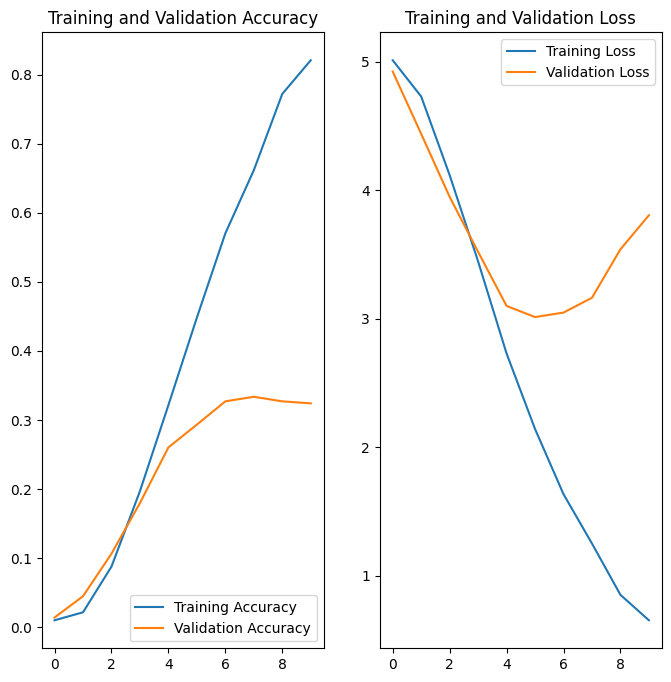

In [74]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [75]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

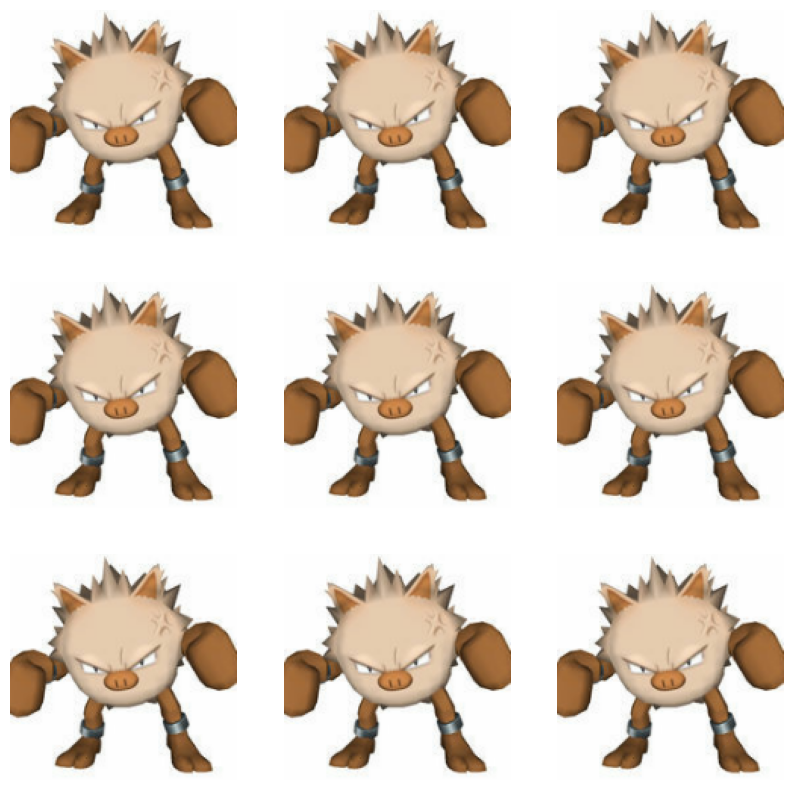

In [76]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [77]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu', activity_regularizers = tf.keras.regularizers.L2(l2=0.01)),
  layers.Dense(num_classes, name="outputs")
])

In [78]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 75, 75, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 37, 37, 32)       0         
 g2D)                                                 

In [81]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
55/55 [==============================] - 31s 564ms/step - loss: 1.5267 - accuracy: 0.5834 - val_loss: 2.0959 - val_accuracy: 0.4714
Epoch 2/20
55/55 [==============================] - 31s 559ms/step - loss: 1.4430 - accuracy: 0.6032 - val_loss: 2.1433 - val_accuracy: 0.4758
Epoch 3/20
55/55 [==============================] - 31s 561ms/step - loss: 1.2910 - accuracy: 0.6538 - val_loss: 2.0403 - val_accuracy: 0.5029
Epoch 4/20
55/55 [==============================] - 31s 561ms/step - loss: 1.2157 - accuracy: 0.6657 - val_loss: 2.1210 - val_accuracy: 0.5073
Epoch 5/20
55/55 [==============================] - 31s 562ms/step - loss: 1.1368 - accuracy: 0.6882 - val_loss: 2.0331 - val_accuracy: 0.5161
Epoch 6/20
55/55 [==============================] - 31s 561ms/step - loss: 1.0789 - accuracy: 0.7047 - val_loss: 2.0232 - val_accuracy: 0.5103
Epoch 7/20
55/55 [==============================] - 31s 573ms/step - loss: 1.0055 - accuracy: 0.7157 - val_loss: 2.0682 - val_accuracy: 0.5315

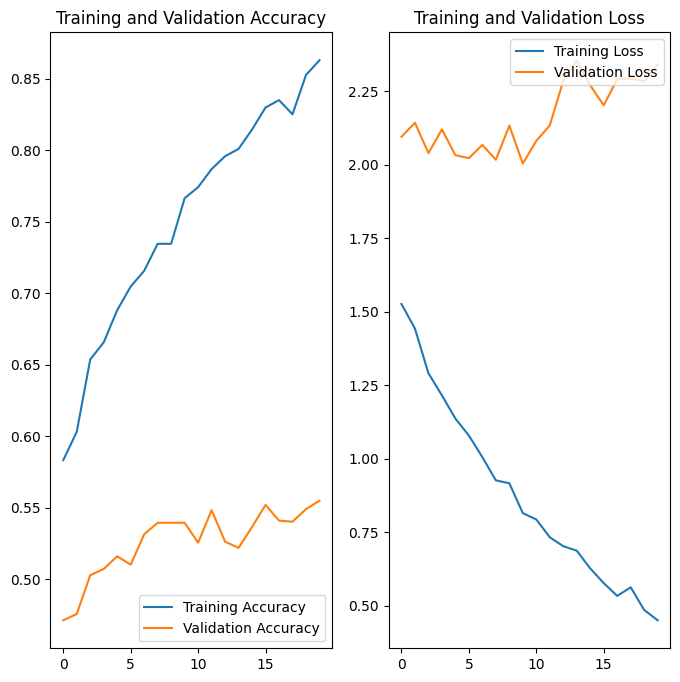

In [82]:
# Visualize training results
# After applying data augmentation and tf.keras.layers.Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned:


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [83]:
epochs = 15
history2 = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
55/55 [==============================] - 34s 615ms/step - loss: 0.4581 - accuracy: 0.8583 - val_loss: 2.3660 - val_accuracy: 0.5513
Epoch 2/15
55/55 [==============================] - 33s 608ms/step - loss: 0.4320 - accuracy: 0.8754 - val_loss: 2.5043 - val_accuracy: 0.5455
Epoch 3/15
55/55 [==============================] - 36s 664ms/step - loss: 0.4086 - accuracy: 0.8776 - val_loss: 2.4362 - val_accuracy: 0.5645
Epoch 4/15
55/55 [==============================] - 35s 629ms/step - loss: 0.4183 - accuracy: 0.8746 - val_loss: 2.4891 - val_accuracy: 0.5462
Epoch 5/15
 8/55 [===>..........................] - ETA: 27s - loss: 0.3513 - accuracy: 0.9021